In [11]:
%matplotlib inline


from typing import Optional, Tuple
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers.experimental import preprocessing


import logging
import math
import pathlib
import random

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io as skio
from skimage import transform, morphology, filters
import matplotlib.pyplot as plt
import numpy as np

from model import residual_unet
from model import losses
from dataset_utils import mk_dataset

In [239]:
class Augment(layers.Layer):
    def __init__(
        self,
        zoom_rate: Optional[Tuple[float, float]] = None,
        flip_mode: Optional[str] = None,
        rotate_rate: Optional[float] = None,
        trans_rate: Optional[float] = None,
        hue: Optional[float] = None,
        brightness: Optional[float] = None,
        contrast: Optional[float] = None,
    ):
        super().__init__()

        seed = 99
        interpolation = "bilinear"
        # interpolation = "nearest"

        self.hue = hue
        self.brightness = brightness

        self.inputs_augment = keras.models.Sequential(name="inputs_augment")
        self.labels_augment = keras.models.Sequential(name="labels_augment")
        # fmt:off
        if zoom_rate is not None:
            self.inputs_augment.add(preprocessing.RandomZoom(zoom_rate, interpolation='bilinear', seed=seed))
            self.labels_augment.add(preprocessing.RandomZoom(zoom_rate, interpolation='bilinear', seed=seed))

        if flip_mode is not None:
            self.inputs_augment.add(preprocessing.RandomFlip(flip_mode, seed=seed))
            self.labels_augment.add(preprocessing.RandomFlip(flip_mode, seed=seed))

        if rotate_rate is not None:
            self.inputs_augment.add(preprocessing.RandomRotation(rotate_rate,  interpolation=interpolation, seed=seed))
            self.labels_augment.add(preprocessing.RandomRotation(rotate_rate,  interpolation=interpolation, seed=seed))

        if trans_rate is not None:
            self.inputs_augment.add(preprocessing.RandomTranslation(trans_rate, trans_rate, interpolation=interpolation, seed=seed))
            self.labels_augment.add(preprocessing.RandomTranslation(trans_rate, trans_rate, interpolation=interpolation, seed=seed))

        if contrast is not None:
            self.inputs_augment.add(preprocessing.RandomContrast(factor=contrast))
        # fmt:on

    def call(self, inputs, labels):
        with tf.device("/CPU:0"):
            inputs = self.inputs_augment(inputs)
            labels = self.labels_augment(labels)
            if self.brightness is not None:
                inputs = tf.image.random_brightness(inputs, max_delta=self.brightness)
            if self.hue is not None:
                inputs = tf.image.random_hue(inputs, max_delta=self.hue)

        return inputs, labels


def aug_factory(geo_aug=True, ch_aug=True):
    augment = None

    aug_param_dic = {}
    if geo_aug:
        aug_param_dic.update(
            {
                "flip_mode": "horizontal_and_vertical",
                "zoom_rate": (-0.3, 0),
                "rotate_rate": 0.2,
            }
        )

    if ch_aug:
        aug_param_dic.update(
            {
                "brightness": 0.2,
                "contrast": 0.2,
            }
        )

    if geo_aug or ch_aug:
        augment = Augment(**aug_param_dic)
    return augment


def gends(ds_root, suffix="png", dsrate=1.0, geo_aug=True, ch_aug=True, batch_size=32):
    ds_root = pathlib.Path(ds_root)

    augment = aug_factory(geo_aug, ch_aug)

    (
        ((tr_sat_pathlist, tr_map_pathlist), tr_steps),
        ((va_sat_pathlist, va_map_pathlist), va_steps),
    ) = mk_dataset.mk_pathlist(ds_root, suffix, batch_size=batch_size, dsrate=dsrate)

    train_ds = mk_dataset.mkds(
        tr_sat_pathlist,
        tr_map_pathlist,
        augment=augment,
        batch_size=batch_size,
    )

    valid_ds = mk_dataset.mkds(
        va_sat_pathlist,
        va_map_pathlist,
        batch_size=batch_size,
        test=True,
    )
    return (train_ds, tr_steps), (valid_ds, va_steps)


def resize(input_image, height=256, width=256):
    input_image = tf.image.resize(input_image, (height, width), method="nearest")
    return input_image


def load_image(path, channels):
    # ファイルから読み込み
    image_f = tf.io.read_file(path)
    # Tensorに変換
    image_jpeg = tf.image.decode_jpeg(image_f, channels=channels)
    # 正規化([0,1])
    normalizer = tf.constant(255.0, dtype=tf.float32)
    image = tf.cast(image_jpeg, tf.float32) / normalizer
    image = resize(image)
    return image


In [243]:
ibr_root = pathlib.Path("../../DataSets/ibarakimap_s17/train")
augment = Augment(flip_mode="horizontal_and_vertical", rotate_rate=0.2)
(((tr_sat_pathlist, tr_map_pathlist), _), _) = mk_dataset.mk_pathlist(
    ibr_root, "jpg", batch_size=32, dsrate=1.0
)
ibrds = mk_dataset.mkds(
    tr_sat_pathlist, tr_map_pathlist, augment=augment, batch_size=32
)
ibr_testds = mk_dataset.mkds(
    tr_sat_pathlist, tr_map_pathlist, test=True, batch_size=32
)

mr_root = pathlib.Path("../../../Datasets/mass_roads9/train/")
augment = Augment(
    zoom_rate=(-0.3, 0),
    flip_mode="horizontal_and_vertical",
    rotate_rate=0.2,
    brightness=0.2,
    contrast=0.2,
)
(((tr_sat_pathlist, tr_map_pathlist), _), _) = mk_dataset.mk_pathlist(
    mr_root,
    "png",
    batch_size=32,
    dsrate=1.0,
)
mrds = mk_dataset.mkds(tr_sat_pathlist, tr_map_pathlist, augment=augment, batch_size=32)


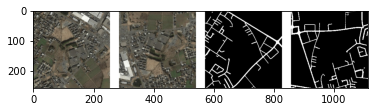

In [249]:
augment = Augment(flip_mode="horizontal_and_vertical", rotate_rate=0.2)
sat_path = str(ibr_root / "sat/697.jpg")
map_path = str(ibr_root / "map/697.jpg")

sat_im = load_image(sat_path, channels=3)
map_im = load_image(map_path, channels=1)

hsep = np.ones((256, 30, 3))
vsep = np.ones((30, 256 * 2 + 30, 3))

org_sat_im = load_image(sat_path, channels=3)
org_map_im = load_image(map_path, channels=1)[..., 0]
org_map_c = np.stack([org_map_im, org_map_im, org_map_im], axis=-1)
org_stacked = np.hstack([org_sat_im, hsep, org_map_c])

sat_im, map_im = augment(sat_im, map_im)
sat_im, map_im = postprocess_map(sat_im, map_im)
map_im = map_im[..., 0]
map_c = np.stack([map_im, map_im, map_im], axis=-1)
aug_stacked = np.hstack([sat_im, hsep, map_c])

stacked = np.hstack([org_sat_im, hsep, sat_im, hsep, org_map_c, hsep, map_c])
# stacked = map_c
plt.imshow(stacked)
skio.imsave("./mapim.png", map_im)
# plt.colorbar()
skio.imsave("../../モデル実験/MyPaper/images/ibr_aug.png", stacked)


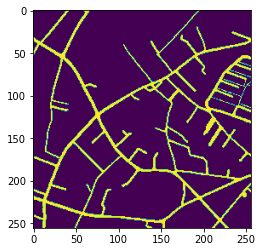

In [244]:
inp, tar = next(iter(ibr_testds))
plt.imshow(tar[0])
skio.imsave('image.png',tar[0])
!o image.png


/var/folders/gn/km0jn9852179zj8mnpblwb6w0000gp/T/ipykernel_42290/452025131.py:6: UserWarning: ./mapim.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  skio.imsave('./mapim.png',mapim)


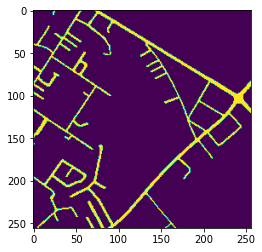

In [218]:
map_path = str(ibr_root / "map/697.jpg")
mapim = skio.imread(map_path)
thr = filters.threshold_otsu(mapim)
mapim = mapim > thr
plt.imshow(mapim)
skio.imsave('./mapim.png',mapim)
!o ./mapim.png


In [246]:
augment = Augment(
    zoom_rate=(-0.3, 0),
    flip_mode="horizontal_and_vertical",
    rotate_rate=0.2,
    brightness=0.2,
    contrast=0.2,
)

def postprocess_map(sats, maps):
    # * 画像を0.5を閾値として0 or 1に変換
    maps = tf.cast(maps > 0.5, dtype=tf.float32)
    return sats, maps


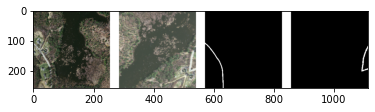

In [252]:
augment = Augment(
    zoom_rate=(-0.3, 0),
    flip_mode="horizontal_and_vertical",
    rotate_rate=0.2,
    brightness=0.2,
    contrast=0.2,
)
sat_path = str(mr_root / "sat/15928825_15_3_0_0.png")
map_path = str(mr_root / "map/15928825_15_3_0_0.png")

sat_im = load_image(sat_path, channels=3)
map_im = load_image(map_path, channels=1)

org_sat_im = load_image(sat_path, channels=3)
org_map_im = load_image(map_path, channels=1)[..., 0]

org_map_c = np.stack([org_map_im, org_map_im, org_map_im], axis=-1)
org_stacked = np.hstack([org_sat_im, hsep, org_map_c])


sat_im, map_im = augment(sat_im, map_im)
map_im = map_im[..., 0]
sat_im, map_im = postprocess_map(sat_im, map_im)
map_c = np.stack([map_im, map_im, map_im], axis=-1)
aug_stacked = np.hstack([sat_im, hsep, map_c])


stacked = np.hstack([org_sat_im, hsep, sat_im, hsep, org_map_c, hsep, map_c])
plt.imshow(stacked)
# skio.imsave("mr_aug.png", stacked)
skio.imsave("../../モデル実験/MyPaper/images/mr_aug.png", stacked)


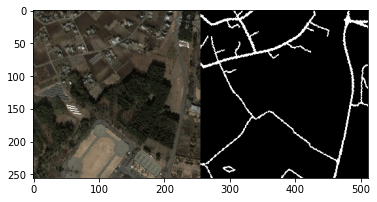

In [52]:
satim = sat_b[0]
mapim = map_b[0, ..., 0]
map_c = np.stack([mapim, mapim, mapim], axis=-1)
stacked = np.hstack([satim, map_c])
plt.imshow(stacked)


In [13]:
data_root = pathlib.Path("../../DataSets/ibarakimap_s17/test")
model_root = pathlib.Path("../../モデル実験/trained_model/")

# mk_dataset.mk_baseds()
map_path_list = list(map(lambda path: str(path), (data_root / "map").glob("*.jpg")))
sat_path_list = list(map(lambda path: str(path), (data_root / "sat").glob("*.jpg")))

metrics = (
    keras.metrics.MeanIoU(num_classes=2, name="mean_iou"),
    keras.metrics.Precision(name="presision"),
    keras.metrics.Recall(name="recall"),
)

result_list = []
loss = losses.DICELoss(name="dice")
for name in model_root.glob("ibr*"):
    print(name)
    ds = mk_dataset.mkds(sat_path_list, map_path_list, batch_size=8, test=True)
    model = keras.models.load_model(name)
    model.compile(loss=loss, metrics=metrics)
    result = model.evaluate(ds)
    result_list.append((name, result))


../../モデル実験/trained_model/ibr05_base_dense


58/58 [==============================] - 120s 2s/step - loss: 0.4268 - mean_iou: 0.6504 - presision: 0.6053 - recall: 0.5420
../../モデル実験/trained_model/ibr10_base_sparse


58/58 [==============================] - 113s 2s/step - loss: 0.4112 - mean_iou: 0.6546 - presision: 0.6059 - recall: 0.5559
../../モデル実験/trained_model/ibr10


58/58 [==============================] - 104s 2s/step - loss: 0.4708 - mean_iou: 0.6542 - presision: 0.5181 - recall: 0.6091
../../モデル実験/trained_model/ibr05_base_sparse


58/58 [==============================] - 111s 2s/step - loss: 0.4498 - mean_iou: 0.6498 - presision: 0.5302 - recall: 0.5870
../../モデル実験/trained_model/ibr10_base05


58/58 [==============================] - 106s 2s/step - loss: 0.4053 - mean_iou: 0.6541 - presision: 0.5407 - recall: 0.5898
../../モデル実験/trained_model/ibr05


58/58 [==============================] - 109s 2s/step - loss: 0.4880 - mean_iou: 0.6474 - presision: 0.5349 - recall: 0.5778
../../モデル実験/trained_model/ibr10_base10


58/58 [==============================] - 107s 2s/step - loss: 0.4473 - mean_iou: 0.6469 - presision: 0.5364 - recall: 0.5742
../../モデル実験/trained_model/ibr10_base_dense


58/58 [==============================] - 114s 2s/step - loss: 0.4072 - mean_iou: 0.6491 - presision: 0.5451 - recall: 0.5736
../../モデル実験/trained_model/ibr05_base10


58/58 [==============================] - 105s 2s/step - loss: 0.4624 - mean_iou: 0.6474 - presision: 0.5443 - recall: 0.5687
../../モデル実験/trained_model/ibr05_base05


58/58 [==============================] - 106s 2s/step - loss: 0.4337 - mean_iou: 0.6480 - presision: 0.5466 - recall: 0.5679


In [30]:
df = pd.DataFrame(dict(result_list)).T
df.columns = ("loss", "mean_iou", "presision", "recall")
df.sort_values("loss")
# with open("ibr_val_result.json", "w") as f:
#     dic = dict(map(lambda kv: (str(kv[0]), kv[1]), result_list))
#     json.dump(dic, fp=f)
df.to_csv('../../ibr_eval.csv')

In [31]:
data_root = pathlib.Path("../../../DataSets/mass_roads9/valtest")
model_root = pathlib.Path("../../モデル実験/trained_model/")

# mk_dataset.mk_baseds()
map_path_list = list(map(lambda path: str(path), (data_root / "map").glob("*.png")))
sat_path_list = list(map(lambda path: str(path), (data_root / "sat").glob("*.png")))
ds = mk_dataset.mk_baseds(sat_path_list, map_path_list).batch(8)
metrics = (
    keras.metrics.MeanIoU(num_classes=2, name="mean_iou"),
    keras.metrics.Precision(name="presision"),
    keras.metrics.Recall(name="recall"),
)

result_list = []
loss = losses.DICELoss(name="dice")
for name in model_root.glob("base*"):
    print(name)
    ds = mk_dataset.mkds(sat_path_list, map_path_list, batch_size=32, test=True)
    model = keras.models.load_model(name)
    model.compile(loss=loss, metrics=metrics)
    result = model.evaluate(ds)
    result_list.append((name, result))

df = pd.DataFrame(dict(result_list)).T
df.columns = ("loss", "mean_iou", "presision", "recall")
df.sort_values("loss")
df.to_csv("../../mass_eval.csv")


../../モデル実験/trained_model/base_sparse


71/71 [==============================] - 153s 2s/step - loss: 0.3537 - mean_iou: 0.7006 - presision: 0.7350 - recall: 0.5438
../../モデル実験/trained_model/base10


71/71 [==============================] - 151s 2s/step - loss: 0.3060 - mean_iou: 0.7277 - presision: 0.7316 - recall: 0.6063
../../モデル実験/trained_model/base_dense


71/71 [==============================] - 173s 2s/step - loss: 0.2859 - mean_iou: 0.7383 - presision: 0.7301 - recall: 0.6420
../../モデル実験/trained_model/base05


71/71 [==============================] - 170s 2s/step - loss: 0.2983 - mean_iou: 0.7432 - presision: 0.7188 - recall: 0.6608


In [4]:
def show_results(images, titles, figsize=(15, 15)):
    nb_images = len(images)
    plt.figure(figsize=figsize)
    for idx, (image, title) in enumerate(zip(images, titles)):
        if len(image.shape) and image.shape[-1] == 1:
            image = image[..., 0]
        plt.subplot(1, nb_images, idx + 1)
        plt.title(title)
        plt.imshow(image, cmap="gray")
    plt.show()


In [5]:
mr_path = pathlib.Path("../../../Datasets/mass_roads9/test")
mr_map = sorted(list((mr_path / "map").glob("*.png")))
mr_sat = sorted(list((mr_path / "sat").glob("*.png")))

ibr_path = pathlib.Path("../../DataSets/ibarakimap_s17/train")
ibr_map = sorted(list((ibr_path / "map").glob("*.jpg")))
ibr_sat = sorted(list((ibr_path / "sat").glob("*.jpg")))


In [6]:
def mk_pathlist(
    ds_root: pathlib.Path, suffix: str, batch_size: int, dsrate: float = 1.0
):
    # * パスのリストを作る
    random.seed(1)
    pathlist = (ds_root / "map").glob(f"*.{suffix}")
    pathlist = sorted([path.name for path in pathlist])
    random.shuffle(pathlist)

    # * 訓練用と検証用に分割
    nb_tr = int(len(pathlist) * 0.8 * dsrate)
    nb_va = int(len(pathlist) * 0.2)
    tr_pathlist = pathlist[:nb_tr]
    va_pathlist = pathlist[nb_tr : nb_tr + nb_va]
    logging.info(f"nb_tr: {nb_tr}")
    logging.info(f"nb_va: {nb_va}")

    # * ステップ数を決める
    tr_sat_pathlist = sorted([str(ds_root / "sat" / path) for path in tr_pathlist])
    tr_map_pathlist = sorted([str(ds_root / "map" / path) for path in tr_pathlist])
    tr_steps = math.ceil(nb_tr / batch_size)

    va_sat_pathlist = sorted([str(ds_root / "sat" / path) for path in va_pathlist])
    va_map_pathlist = sorted([str(ds_root / "map" / path) for path in va_pathlist])
    va_steps = math.ceil(nb_va / batch_size)

    return (
        ((tr_sat_pathlist, tr_map_pathlist), tr_steps),
        ((va_sat_pathlist, va_map_pathlist), va_steps),
    )


In [50]:
sum_list = []
for idx, path in enumerate(tqdm(tr_map_pathlist)):
    im = skio.imread(path, as_gray=True)
    thr = filters.threshold_otsu(im)
    im = im > thr
    im = morphology.skeletonize(im)
    imsum = np.sum(im)
    sum_list.append((idx, imsum))


NameError: name 'tr_map_pathlist' is not defined

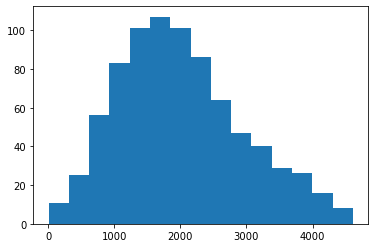

In [59]:
sum_array = np.array(sum_list)
_ = plt.hist(sum_array[..., 1], bins=15)


In [7]:
ibr_path = pathlib.Path("../../DataSets/ibarakimap_s17/test")
ibr_map = sorted(list((ibr_path / "map").glob("*.jpg")))
ibr_sat = sorted(list((ibr_path / "sat").glob("*.jpg")))

csv_root = pathlib.Path("/Users/hagayuya/GradRes/モデル実験/transfered")
result_df = pd.read_csv(
    "/Users/hagayuya/GradRes/モデル実験/transfered/DICE-DA_GEO-IM_1.0-E100_base0.5/test_100.csv"
)
i = 8
idx = result_df.query(f"bin_idx == {i}")["loss"].idxmin()
plt.imshow(skio.imread(ibr_map[idx])); plt.show()
plt.imshow(skio.imread(ibr_sat[idx])); plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/hagayuya/GradRes/モデル実験/transfered/DICE-DA_GEO-IM_1.0-E100_base0.5/test_100.csv'

1.0


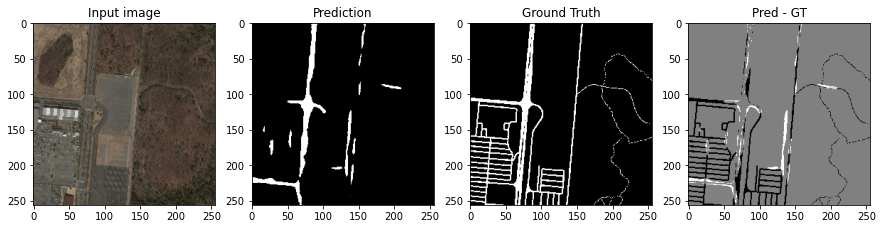

In [62]:
keras.backend.clear_session()
csv_root = pathlib.Path("/Users/hagayuya/GradRes/モデル実験/transfered")

name = "DICE-DA_GEO-IM_1.0-E100_base0.5"
dataset = "test"

ibr_path = pathlib.Path(f"../../DataSets/ibarakimap_s17/{dataset}")
ibr_map = sorted(list((ibr_path / "map").glob("*.jpg")))
ibr_sat = sorted(list((ibr_path / "sat").glob("*.jpg")))

result_df = pd.read_csv(
    f"/Users/hagayuya/GradRes/モデル実験/transfered/{name}/{dataset}_100.csv"
)
i = 5
idx = int(result_df.query(f"bin_idx == {i}")["loss"].idxmax())

# model = residual_unet.unet(input_shape=(256, 256, 3), name="basemodel")
# path = f"/Users/hagayuya/GradRes/experiments_autolr/checkpoints/{name}/{name}_100"
# model.load_weights(path)


im = skio.imread(ibr_sat[idx]) / 255.0
gt = skio.imread(ibr_map[idx], as_gray=True)
thr_gt = filters.threshold_otsu(gt)
gt = (gt > thr_gt).astype("float")

pred = model.predict(im[None])[0, ..., 0]
print(gt.max())

show_results(
    (im, pred, gt, pred - gt),
    ("Input image", "Prediction", "Ground Truth", "Pred - GT"),
)


(3, 1, 256, 256)

1159995.0


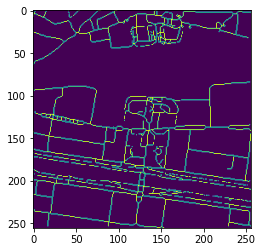

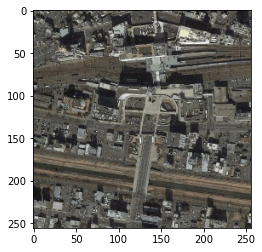

In [42]:
dataset = "test"
ibr_path = pathlib.Path(f"../../DataSets/ibarakimap_s17/{dataset}")
ibr_map = sorted(list((ibr_path / "map").glob("*.jpg")))
ibr_sat = sorted(list((ibr_path / "sat").glob("*.jpg")))

result_df = pd.read_csv(
    f"/Users/hagayuya/GradRes/モデル実験/transfered/DICE-DA_GEO-IM_1.0-E100_base0.5/{dataset}_100.csv"
)

idx = int(result_df["map_sum"].idxmax())
print(result_df["map_sum"][idx])

im = skio.imread(ibr_map[idx], as_gray=True)
thr = filters.threshold_otsu(im)
im = im > thr
im = morphology.skeletonize(im)

plt.imshow(im)
plt.show()
plt.imshow(skio.imread(ibr_sat[idx]))
plt.show()


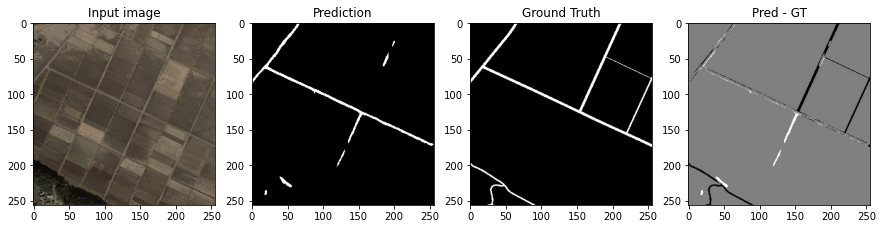

In [90]:

im = skio.imread(ibr_sat[idx]) / 255.0
pred = model.predict(im[None])[0]
gt = skio.imread(ibr_map[idx], as_gray=True)[..., None] / 255.0

show_results(
    (im, pred, gt, pred - gt),
    ("Input image", "Prediction", "Ground Truth", "Pred - GT"),
)


/Users/hagayuya/GradRes/モデル実験/transfered/ibr10/train_100.csv
Index(['idx', 'map_sum', 'loss', 'iou', 'bin_idx'], dtype='object')


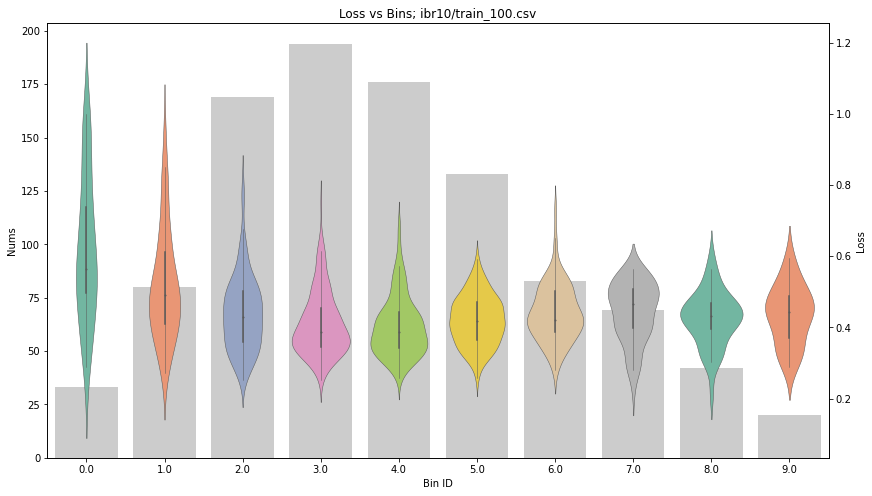

/Users/hagayuya/GradRes/モデル実験/transfered/ibr10_base05/train_100.csv
Index(['idx', 'map_sum', 'loss', 'iou', 'bin_idx'], dtype='object')


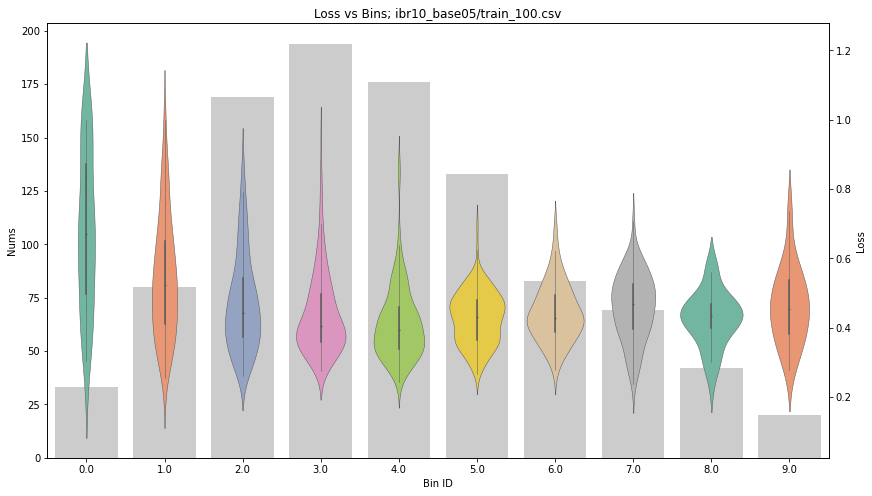

/Users/hagayuya/GradRes/モデル実験/transfered/ibr05/train_100.csv
Index(['idx', 'map_sum', 'loss', 'iou', 'bin_idx'], dtype='object')


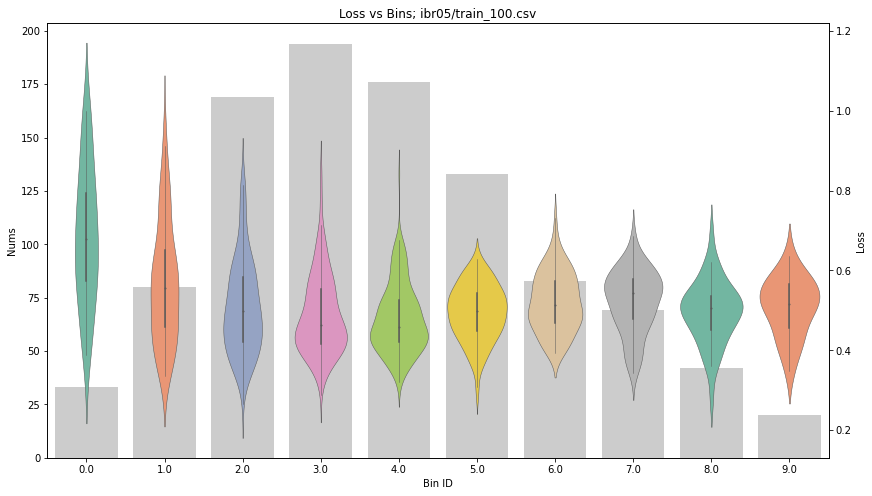

/Users/hagayuya/GradRes/モデル実験/transfered/ibr10_base10/train_100.csv
Index(['idx', 'map_sum', 'loss', 'iou', 'bin_idx'], dtype='object')


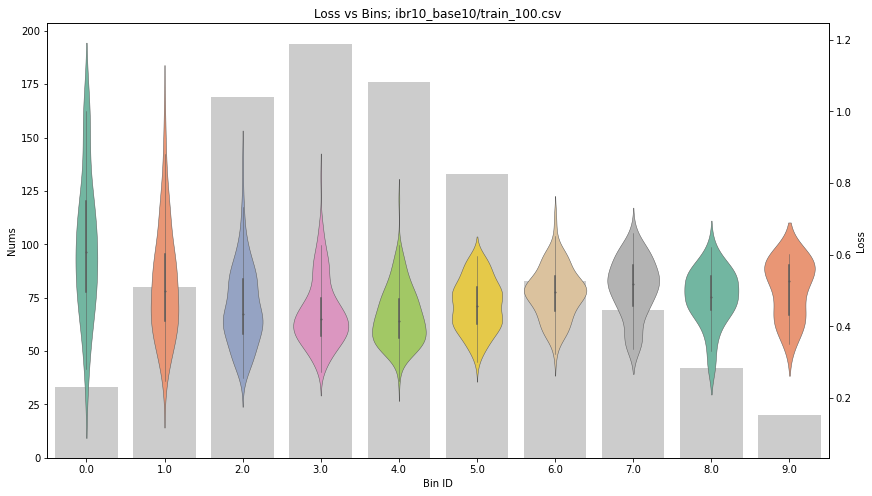

/Users/hagayuya/GradRes/モデル実験/transfered/ibr05_base10/train_100.csv
Index(['idx', 'map_sum', 'loss', 'iou', 'bin_idx'], dtype='object')


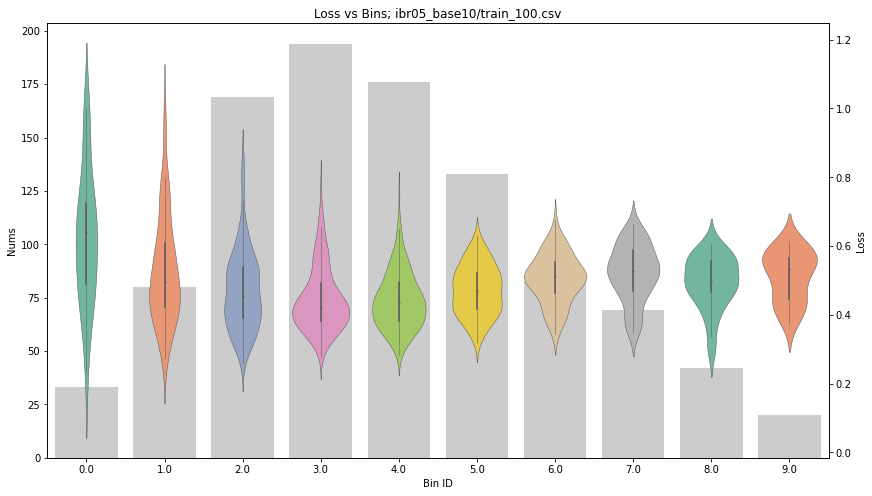

/Users/hagayuya/GradRes/モデル実験/transfered/ibr05_base05/train_100.csv
Index(['idx', 'map_sum', 'loss', 'iou', 'bin_idx'], dtype='object')


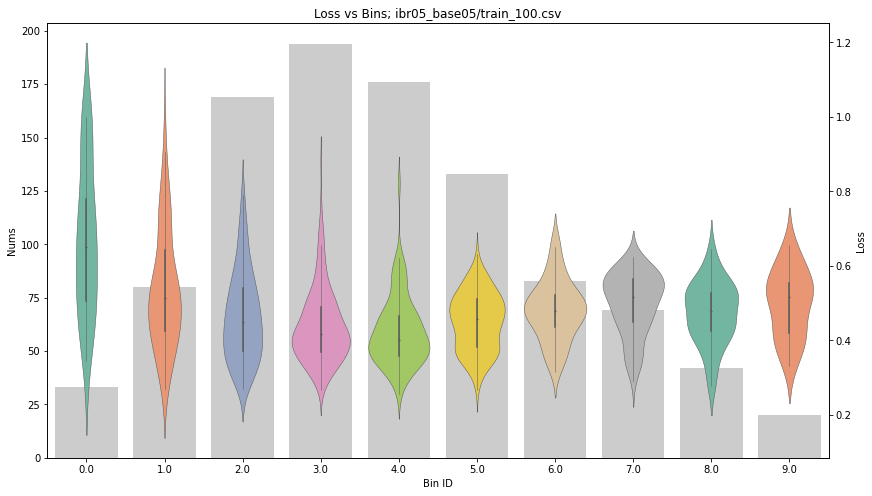

In [17]:
def plot_violin(csv_path):
    result_df = pd.read_csv(csv_path)
    print(result_df.columns)
    ####
    bins = 10
    nums, edges = np.histogram(result_df["map_sum"], bins=bins)
    result_df["bin_idx"] = np.nan
    sums = 0
    for bin_idx, edge_idx in enumerate(range(len(edges) - 1)):
        result_df["bin_idx"][
            (
                (result_df["map_sum"] >= edges[edge_idx])
                * (result_df["map_sum"] < edges[edge_idx + 1])
            )
        ] = bin_idx
    ###
    height = [
        np.sum(result_df["bin_idx"] == id)
        for id in np.sort(np.unique(result_df["bin_idx"]))
    ]
    left = list(range(len(height)))

    fig, ax1 = plt.subplots(figsize=(14, 8))
    ax2 = ax1.twinx()
    ax1.bar(left, height, color="0.8", label="nums per bin")
    ax1.set_xlabel("Bin ID")
    ax1.set_ylabel("Nums")
    plt.title(f"Loss vs Bins; {csv_path.parent.name}/{csv_path.name}")
    palette = sns.color_palette("Set2")
    sns.violinplot(
        x=result_df["bin_idx"],
        y=result_df["loss"],
        ax=ax2,
        palette=palette,
        linewidth=0.5,
    )
    ax2.set_ylabel("Loss")
    plt.savefig("./output.jpg")
    plt.show()
    return result_df


for csv_path in csv_root.glob("**/train_100.csv"):
    print(csv_path)
    result_df = plot_violin(csv_path)


In [18]:
result_df.query("bin_idx == 5")["loss"].var()

var_list = []
mean_list = []
for i in left:
    desc = result_df.query(f"bin_idx == {i}")["loss"].describe()
    var_list.append(desc["std"])
    mean_list.append(desc["mean"])
plt.plot(var_list, label="var")
plt.plot(mean_list, label="mean")
plt.legend()

result_df.query("bin_idx == 5")["loss"].describe()["mean"]


NameError: name 'left' is not defined

In [24]:
sum_array = np.array(sum_list)
df = pd.read_csv("base_results.csv")


,edge_id,idx,loss05,iou05,loss10,iou10,sum
6020,2.0,8196.0,0.218732,0.641095,0.235908,0.618292,2961
6021,2.0,8197.0,0.592821,0.255778,0.507093,0.327187,2310
2471,0.0,8198.0,1.000000,0.000819,1.000000,0.000819,657
2472,0.0,8199.0,1.000000,0.000535,1.000000,0.000529,232
2473,0.0,8200.0,1.000000,0.000867,1.000000,0.000867,618


In [4]:
df = pd.read_csv("base_results.csv")
sum_array = np.array(sum_list)
bins = 20
nums, edges = np.histogram(sum_array[..., 1], bins=bins)

edges.shape
sums = sum_array[..., 1]
df.to_clipboard()

for idx, edge in enumerate(edges[:-1]):
    start = edges[idx]
    end = edges[idx + 1]

    print(sum_array[(sums > start) * (sums < end), ::][:5])

sum_array[..., 1]


NameError: name 'sum_list' is not defined

edge_id idx loss05 iou05 loss10 iou10


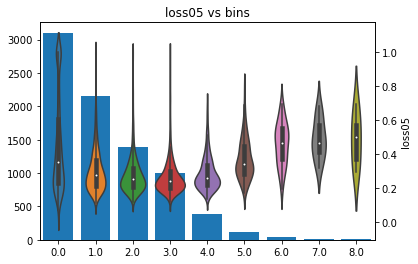

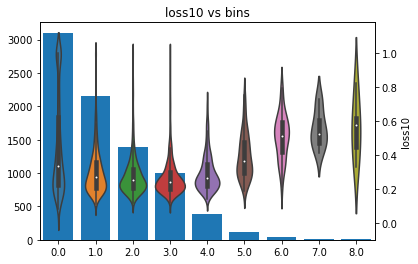

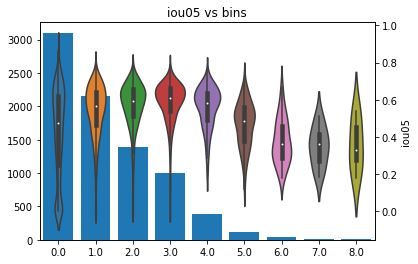

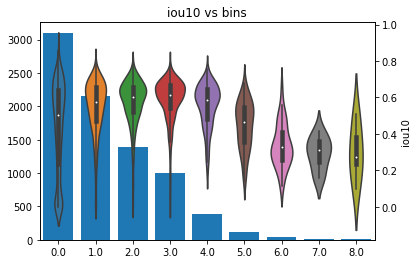

In [6]:
print("edge_id", "idx", "loss05", "iou05", "loss10", "iou10")
ar = np.concatenate(metrics_array)

height = nums
left = list(range(len(nums)))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.bar(left, height)
plt.title("loss05 vs bins")
plt.xlabel("bins")
plt.ylabel("loss05")
sns.violinplot(x=ar[::, 0], y=ar[::, 2], ax=ax2)
plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.bar(left, height)
plt.title("loss10 vs bins")
plt.xlabel("bins")
plt.ylabel("loss10")
sns.violinplot(x=ar[::, 0], y=ar[::, 4], ax=ax2)
fig.savefig("output.png", dpi=100)
plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.bar(left, height)
plt.title("iou05 vs bins")
plt.xlabel("bins")
plt.ylabel("iou05")
sns.violinplot(x=ar[::, 0], y=ar[::, 3], ax=ax2)
plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.bar(left, height)
plt.title("iou10 vs bins")
plt.xlabel("bins")
plt.ylabel("iou10")
sns.violinplot(x=ar[::, 0], y=ar[::, 5], ax=ax2)
plt.show()


In [220]:
df = pd.DataFrame(ar, columns=("edge_id", "idx", "loss05", "iou05", "loss10", "iou10"))
df.to_csv("base_results.csv", index=False)


In [ ]:
import pandas as pd
from sklearn.datasets import load_boston

data = load_boston()
name = pd.DataFrame(data.target).rename(columns={0: "name"})
df = pd.DataFrame(data.data, columns=data.feature_names).merge(
    name, left_index=True, right_index=True
)
df = pd.DataFrame(data.data, columns=data.feature_names)
df = df.loc[df["RAD"] < 5]


<AxesSubplot:>

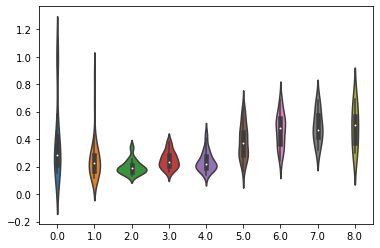

In [173]:
ar0 = metrics_array[0]
ar1 = metrics_array[1]
ar = np.concatenate(metrics_array)
sns.violinplot(x=ar[::, 0], y=ar[::, 2])


In [ ]:
num = 10
for _ in range(num):
    sat_path, map_path = random.choice(list(zip(mr_sat, mr_map)))

    im = skio.imread(sat_path)
    tar = skio.imread(map_path)
    im = transform.resize(im, (256, 256))
    pred05 = model_05.predict(im[None])[0]
    pred10 = model_10.predict(im[None])[0]
    show_results((im, pred05, pred10, tar), (sat_path.name, "pred05", "pred10", "GT"))


In [ ]:
sat_path = mr_path / "sat" / "23128930_15_3_2_1.png"
map_path = mr_path / "map" / "23128930_15_3_2_1.png"
im = skio.imread(sat_path)
im = transform.resize(im, (256, 256))
tar = skio.imread(map_path)

for idx in range(5, 50, 5):
    print(f"{idx:03d}")
    _model = None
    _model = train.build_model()
    _name = "DICE-DA_GEO_CH-MR9_1.0-E50"
    _model.load_weights(model_root / _name / f"{_name}_{idx:03d}")

    pred = _model.predict(im[None])[0]
    show_results((im, pred, tar), (sat_path.name, "pred", "GT"))


In [ ]:
im.shape
np.stack((im, im, im)).shape
